In [33]:
import pandas as pd

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import os

!pip install pyLDAvis
import pyLDAvis.gensim_models

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
df_final = pd.read_csv("../data/csv/df_clean.csv")
print(df_final.shape)
df_final.head()

(28005, 24)


,paperId,docType,keywords,keywordsPlus,subjectSub1,subjectCat1,subjectCatExt,categoryHeading,abstract,year,...,location,orgNames,orgEnhanced1,orgEnhancedAll,fullName,researcherId,authorSeq,firstAuthorSource,abstract_word_count,contains_keyword
0,WOS:000400551000003,Article,"computational materials science,nanostructures...",NaN,Technology,"Materials Science, Multidisciplinary",Materials Science,Science & Technology,Nanomaterial-based ultra-low-energy device des...,2016,...,NaN,West Bengal Univ Technol,Maulana Abul Kalam Azad University of Technology,Maulana Abul Kalam Azad University of Technology,"Purkayastha, Tamoghna",FSQ-0224-2022,1,seq1_unique,199,True
1,WOS:000400701200001,Article,NaN,NaN,Physical Sciences,"Physics, Applied",Physics,Science & Technology,A challenge for constructing large circuits of...,2016,...,AP,IBM TJ Watson Res Ctr,International Business Machines (IBM),International Business Machines (IBM);IBM USA,"McKay, David C.",GWM-2403-2022,1,seq1_unique,124,True
2,WOS:000399549500014,Article,NaN,"PASTA-ULAM PROBLEM,1-F NOISE,THERMAL AGITATION...",Technology,"Computer Science, Theory & Methods","Computer Science,Instruments & Instrumentation...",Science & Technology,Fluctuations with 1/f spectrum stand for the f...,2016,...,AC,IMT Bucharest,National Institute Research & Development Micr...,National Institute Research & Development Micr...,"Mihaila, M.",FKV-4690-2022,1,seq1_unique,445,True
3,WOS:000397944800010,Article,"Quantum Key Distribution,Bell States,Quantum C...","PRIVACY AMPLIFICATION,CRYPTOGRAPHY,INFORMATION...",Technology,"Computer Science, Information Systems",Computer Science,Science & Technology,A quantum key distribution protocol with tradi...,2016,...,AC,Shenzhen Univ,Shenzhen University,Shenzhen University,"Wang, Ting",JUD-9931-2023,1,seq1_unique,137,True
4,WOS:000398221800009,Article,"quantum cryptography,authentication,key distri...",NaN,Technology,"Computer Science, Information Systems","Computer Science,Telecommunications",Science & Technology,"In this paper, we review a previous research p...",2016,...,NaN,Natl Engn Sch Tunis,Universite de Tunis-El-Manar,Universite de Tunis-El-Manar;Ecole Nationale d...,"Ghilen, Aymen",GAU-3999-2022,1,seq1_unique,126,True


In [26]:
#https://scholarspace.manoa.hawaii.edu/server/api/core/bitstreams/48b93f3c-fb3f-472b-8a13-28a63a423d5f/content

# Initialize tokenizer, lemmatizer, and stopwords
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    if pd.isna(text):
        return []
    tokens = tokenizer.tokenize(text.lower())
    tokens = [t for t in tokens if not t.isnumeric()]       # Remove pure numbers
    tokens = [t for t in tokens if len(t) > 1]              # Remove 1-char tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return tokens

# Preprocess each abstract as one document
docs = df_final['abstract'].apply(preprocess).tolist()

# Build bigrams model (with min_count=20)
bigram = Phrases(docs, min_count= 5, threshold=10)

# Append bigrams to documents
docs_with_bigrams = []
for doc in docs:
    bigrams_in_doc = [token for token in bigram[doc] if '_' in token]
    docs_with_bigrams.append(doc + bigrams_in_doc)

# Build trigram model (min_count and threshold can be tuned)
trigram = Phrases(docs_with_bigrams, min_count= 5, threshold=10)

# Append trigrams to documents
docs_with_trigrams = []
for doc in docs_with_bigrams:
    trigrams_in_doc = [token for token in trigram[doc] if '_' in token]
    docs_with_trigrams.append(doc + trigrams_in_doc)

# Create dictionary and filter extremes (remove tokens appearing <20 docs)
dictionary = Dictionary(docs_with_trigrams)
# dictionary.filter_extremes(no_below=20, no_above = 0.3) #no_above <- I remove this

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in docs_with_trigrams]

print(f"Number of unique tokens: {len(dictionary)}")
print(f"Number of documents: {len(corpus)}")


Number of unique tokens: 52595
Number of documents: 28005


In [27]:
# Get (token, doc_freq) pairs
token_freqs = [(dictionary[id], freq) for id, freq in dictionary.dfs.items()]

# Sort descending by frequency
token_freqs_sorted = sorted(token_freqs, key=lambda x: x[1], reverse=True)

# Show top 10 tokens with their document counts
for token, freq in token_freqs_sorted[:100]:
    print(f"Token: '{token}', Document Frequency: {freq}")

Token: 'quantum', Document Frequency: 26949
Token: 'state', Document Frequency: 13973
Token: 'information', Document Frequency: 12288
Token: 'application', Document Frequency: 12238
Token: 'system', Document Frequency: 11150
Token: 'two', Document Frequency: 10212
Token: 'based', Document Frequency: 9668
Token: 'using', Document Frequency: 8869
Token: 'show', Document Frequency: 8690
Token: 'result', Document Frequency: 8343
Token: 'used', Document Frequency: 8210
Token: 'single', Document Frequency: 7345
Token: 'also', Document Frequency: 7232
Token: 'one', Document Frequency: 7136
Token: 'optical', Document Frequency: 6803
Token: 'time', Document Frequency: 6613
Token: 'high', Document Frequency: 6536
Token: 'field', Document Frequency: 6512
Token: 'photon', Document Frequency: 6190
Token: 'use', Document Frequency: 6110
Token: 'device', Document Frequency: 5970
Token: 'method', Document Frequency: 5912
Token: 'measurement', Document Frequency: 5653
Token: 'present', Document Frequen

In [28]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=400,
    num_topics=10,
    passes=20,
    eval_every=None)

#5m 1.3s


In [31]:
lda_model.save('../data/model/model_v01/lda_default.model')

In [30]:
lda_model.show_topics(formatted=False)

[(0,
  [('time_dependent', 0.017432446),
   ('spin', 0.017369056),
   ('color_center', 0.01066481),
   ('phonon', 0.010000593),
   ('magnetic', 0.009600789),
   ('promising_candidate', 0.009440901),
   ('center', 0.009229366),
   ('zero_phonon', 0.0085077565),
   ('temperature', 0.008482691),
   ('magnetic_field', 0.008427485)]),
 (1,
  [('network', 0.030727582),
   ('neural_network', 0.026095066),
   ('elsevier_right', 0.017222265),
   ('neural', 0.015010859),
   ('secure_communication', 0.014004213),
   ('right', 0.012500025),
   ('elsevier', 0.010905078),
   ('reserved', 0.009694172),
   ('random_number', 0.009361085),
   ('right_reserved', 0.007892293)]),
 (2,
  [('quantum', 0.022775628),
   ('partial_differential', 0.01025093),
   ('question_whether', 0.010162646),
   ('system', 0.009611576),
   ('theory', 0.009401524),
   ('information', 0.008059266),
   ('measurement', 0.007785497),
   ('state', 0.0077745765),
   ('result', 0.006852766),
   ('variational', 0.006524998)]),
 (3,
 

In [32]:
# !pip install pyLDAvis
# import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, '../data/html/model_v01/lda_default.html')


In [39]:
def compute_coherence_values_lda_model(dictionary, corpus, texts, limit, start=2, step=6, save_dir="../data/model/model_v01"):
    """
    Train and save LDA models for various topic numbers. Also compute c_v coherence.

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of tokenized texts
    limit : Max number of topics
    save_dir : Directory to save models

    Returns:
    -------
    model_list : List of LDA models
    coherence_values : Corresponding coherence values
    """
    os.makedirs(save_dir, exist_ok=True)

    coherence_values_lda = []
    model_list_lda = []

    for num_topics in range(start, limit, step):
        print(f"Training model with {num_topics} topics...")

        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            chunksize=2000,
            alpha='auto',
            eta='auto',
            iterations=400,
            passes=20,
            eval_every=None
        )

        # Save model to disk
        model_path = os.path.join(save_dir, f"lda_model_{num_topics}.model")
        lda_model.save(model_path)

        model_list_lda.append(lda_model)

        # Compute coherence
        coherencemodel_lda = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherencemodel_lda.get_coherence()
        coherence_values_lda.append(coherence)

        print(f"Model with {num_topics} topics → Coherence: {coherence:.4f} (saved to {model_path})")

    return model_list_lda, coherence_values_lda


In [40]:
model_list, coherence_values = compute_coherence_values_lda_model(
    dictionary=dictionary,
    corpus=corpus,
    texts=docs_with_trigrams,
    start=6,
    limit=35,
    step=2
)

# Training model with 2 topics...
# Model with 2 topics → Coherence: 0.3736 (saved to ../data/model/model_v01/lda_model_2.gensim)
# Training model with 4 topics...
# Model with 4 topics → Coherence: 0.4618 (saved to ../data/model/model_v01/lda_model_4.gensim)
# Training model with 6 topics...
# Model with 6 topics → Coherence: 0.4623 (saved to ../data/model/model_v01/lda_model_6.model)
# Training model with 8 topics...
# Model with 8 topics → Coherence: 0.4359 (saved to ../data/model/model_v01/lda_model_8.model)
# Training model with 10 topics...
# Model with 10 topics → Coherence: 0.4835 (saved to ../data/model/model_v01/lda_model_10.model)
# Training model with 12 topics...
# Model with 12 topics → Coherence: 0.4827 (saved to ../data/model/model_v01/lda_model_12.model)
# Training model with 14 topics...
# Model with 14 topics → Coherence: 0.4314 (saved to ../data/model/model_v01/lda_model_14.model)
# Training model with 16 topics...
# Model with 16 topics → Coherence: 0.4534 (saved to ../data/model/model_v01/lda_model_16.model)
# Training model with 18 topics...
# Model with 18 topics → Coherence: 0.4503 (saved to ../data/model/model_v01/lda_model_18.model)
# Training model with 20 topics...
# Model with 20 topics → Coherence: 0.4507 (saved to ../data/model/model_v01/lda_model_20.model)
# Training model with 22 topics...
# Model with 22 topics → Coherence: 0.4559 (saved to ../data/model/model_v01/lda_model_22.model)
# Training model with 24 topics...
# Model with 24 topics → Coherence: 0.4494 (saved to ../data/model/model_v01/lda_model_24.model)
# Training model with 26 topics...
# Model with 26 topics → Coherence: 0.4396 (saved to ../data/model/model_v01/lda_model_26.model)
# Training model with 28 topics...
# Model with 28 topics → Coherence: 0.4554 (saved to ../data/model/model_v01/lda_model_28.model)
# Training model with 30 topics...
# Model with 30 topics → Coherence: 0.4533 (saved to ../data/model/model_v01/lda_model_30.model)
# Training model with 32 topics...
# Model with 32 topics → Coherence: 0.4321 (saved to ../data/model/model_v01/lda_model_32.model)


#114 
#53 12
#42 m 

Training model with 6 topics...
Model with 6 topics → Coherence: 0.4623 (saved to ../data/model/model_v01/lda_model_6.model)
Training model with 8 topics...
Model with 8 topics → Coherence: 0.4359 (saved to ../data/model/model_v01/lda_model_8.model)
Training model with 10 topics...
Model with 10 topics → Coherence: 0.4835 (saved to ../data/model/model_v01/lda_model_10.model)
Training model with 12 topics...
Model with 12 topics → Coherence: 0.4827 (saved to ../data/model/model_v01/lda_model_12.model)
Training model with 14 topics...
Model with 14 topics → Coherence: 0.4314 (saved to ../data/model/model_v01/lda_model_14.model)
Training model with 16 topics...
Model with 16 topics → Coherence: 0.4534 (saved to ../data/model/model_v01/lda_model_16.model)
Training model with 18 topics...
Model with 18 topics → Coherence: 0.4503 (saved to ../data/model/model_v01/lda_model_18.model)
Training model with 20 topics...
Model with 20 topics → Coherence: 0.4507 (saved to ../data/model/model_v01/ld

In [41]:
coherence_values 

[0.46226068659352343,
 0.4359153971691118,
 0.4835076473816479,
 0.48266744969595304,
 0.43137470650298054,
 0.45344681651519947,
 0.4503460137552573,
 0.45068057776875375,
 0.45590190407413816,
 0.4494108909532318,
 0.4395701995676993,
 0.45535280231773134,
 0.45331639686096953,
 0.4320836800837683,
 0.44810023291528983]

Loaded model 2 → Coherence: 0.3736
Loaded model 4 → Coherence: 0.4618


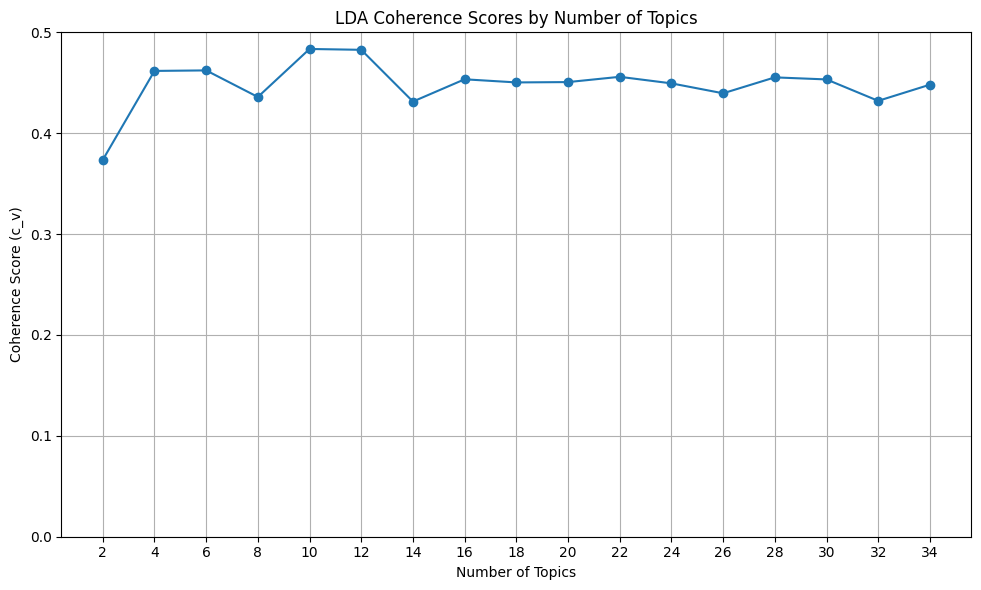

In [ ]:
import matplotlib.pyplot as plt

# Define path and parameters
save_dir = "../data/model/model_v01"
topics_to_fill = [2, 4]  # Topics for which you already saved models but haven't computed coherence
coherence_dict = {}      # Collect all coherence values here

# Start with your existing scores (example; fill with your actual data)
existing_topics = list(range(6, 35, 2))  # e.g., [6, 12, 18, ..., limit]
existing_coherence_values = coherence_values  # The list you already returned

# Add them to dict
for t, score in zip(existing_topics, existing_coherence_values):
    coherence_dict[t] = score

# Now add coherence for topic=2 and 4
for t in topics_to_fill:
    model_path = os.path.join(save_dir, f"lda_model_{t}.model")
    if os.path.exists(model_path):
        lda_model = gensim.models.ldamodel.LdaModel.load(model_path)
        coherencemodel = CoherenceModel(model=lda_model, texts=docs_with_trigrams, dictionary=dictionary, coherence='c_v')
        coherence = coherencemodel.get_coherence()
        coherence_dict[t] = coherence
        print(f"Loaded model {t} → Coherence: {coherence:.4f}")
    else:
        print(f"Model for topic {t} not found at {model_path}")

# Sort by topic number
sorted_topics = sorted(coherence_dict.keys())
sorted_scores = [coherence_dict[t] for t in sorted_topics]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_topics, sorted_scores, marker='o')
plt.title('LDA Coherence Scores by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.xticks(sorted_topics)
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 0.5)
plt.savefig('../data/model/model_v01/coherence.png')

plt.show()


In [46]:
optimized_lda_model = LdaModel.load('../data/model/model_v01/lda_model_10.model')

In [49]:
optimized_lda_model.show_topics(formatted=False)

[(0,
  [('quantum', 0.03497037),
   ('state', 0.020664196),
   ('system', 0.012588944),
   ('measurement', 0.010713354),
   ('information', 0.0096681155),
   ('theory', 0.0071277334),
   ('result', 0.00567223),
   ('show', 0.0053645577),
   ('entanglement', 0.0052017197),
   ('non', 0.005113797)]),
 (1,
  [('photon', 0.03542319),
   ('single_photon', 0.028446997),
   ('quantum', 0.023740506),
   ('optical', 0.01781405),
   ('single', 0.014429586),
   ('hep', 0.0098784845),
   ('physic_hep', 0.009873077),
   ('high', 0.009396767),
   ('mode', 0.008621124),
   ('photonic', 0.00793359)]),
 (2,
  [('quantum', 0.03149545),
   ('state', 0.019203084),
   ('protocol', 0.016946563),
   ('scheme', 0.013078023),
   ('entanglement', 0.010062911),
   ('entangled_state', 0.010033232),
   ('communication', 0.008851018),
   ('two', 0.008190635),
   ('based', 0.007827691),
   ('entangled', 0.00762416)]),
 (3,
  [('quantum', 0.01564438),
   ('system', 0.014952963),
   ('information_processing', 0.012324

In [48]:
# Visualize with pyLDAvis
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(optimized_lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, '../data/html/model_v01/lda_model_10_visualization.html')